In [5]:
%matplotlib inline
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import math
import os
from torch.autograd import Variable as V
from numpy.linalg import inv
import cv2
import random

### Support Functions

In [106]:
# os.chdir("C:/Users/yh/Desktop/")
def affine_transform(input,mat):
    coor=coordinate_one()
    xyprime=t.tensordot(coor,t.t(mat),dims=1)
    return bilinear(input,xyprime)

def coordinate():
    coor=np.asarray(np.meshgrid(np.arange(xsize), np.arange(ysize)))
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,2)
    return V(t.tensor(coor),True)

def coordinate_one():
    coor=np.asarray(np.meshgrid(np.arange(xsize), np.arange(ysize)))
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,2)
    onesMatrix = np.ones((xsize,ysize,1))
    coorMatrix = np.concatenate((coor, onesMatrix), axis=2)
    return V(t.tensor(coorMatrix),True)

def nearest_neighbor(img,xyprime):
    xp=t.round(xyprime[:,:,0]).long()
    yp=t.round(xyprime[:,:,1]).long()
    xp=t.where(xp>xsize-1,t.tensor(xsize-1),xp)
    yp=t.where(yp>ysize-1,t.tensor(ysize-1),yp)
    return img[xp,yp]
    
def bilinear(img,xyprime):
    xp=xyprime[:,:,0]
    yp=xyprime[:,:,1]
    LUX=t.floor(xp).int()
    LUY=t.floor(yp).int()
    LUX=t.where(LUX>xsize-2,t.tensor(xsize-2),LUX.long())
    LUX=t.where(LUX<1,t.tensor(1),LUX)
    LUY=t.where(LUY>ysize-2,t.tensor(ysize-2),LUY.long())
    LUY=t.where(LUY<1,t.tensor(1),LUY)
    [a,b]=[yp-LUY.double(),xp-LUX.double()]
    [k00,k01,k10,k11]=[img[LUX,LUY],img[LUX,LUY+1],img[LUX+1,LUY],img[LUX+1,LUY+1]]
    return (1-b)*(a*k01+(1-a)*k00)+b*(a*k11+(1-a)*k10)   

def randxy(img,rate):
    zeros = t.zeros(img.shape)
    xsize, ysize = img.shape
    i = 0
    flatten_indexes = [i for i in range(xsize*ysize)]
    choices = random.sample(flatten_indexes, int(rate*len(flatten_indexes)))
    for i in range(len(choices)):
        zeros[choices[i]//ysize][choices[i]%xsize] = 1
    return zeros
    
def imshow(template, transformed, reference):
    plt.figure(2)
    plt.subplot(1,3,1)
    plt.imshow(template)
    plt.title("Template")
    
    plt.subplot(1,3,2)
    plt.imshow(transformed)
    plt.title("Transformed")
    
    plt.subplot(1,3,3)
    plt.imshow(reference)
    plt.title("Reference")
    plt.show()

In [107]:
def gradient_decent(template, reference, iteration=1000, learning_rate=1e-9):
    matrix = V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
    losses = []
    rate = 0.01
    for i in range(iteration):    
        transformed = affine_transform(template,matrix)
        error = reference - transformed
        loss = t.sum(error[randxy(template, rate) == 1] ** 2)   
        loss.backward(retain_graph=True)
        losses.append(np.sum((transformed.detach().numpy()-reference.detach().numpy())**2))
        with t.no_grad():
            matrix[:2,:]-=step*matrix.grad[:2,:]
            matrix.grad.zero_()
    plt.plot(np.arange(iteration), losses)
    imshow(template.data.numpy(),transformed.data.numpy(),reference.data.numpy())
    print("last loss:", losses[-1])
    print("last gradient:", matrix.grad[:2, :])
    

### Hand Test Cases

In [108]:
hand_template = plt.imread('hand.jpg')
hand_template = V(t.Tensor(hand_template).double(), True)
# hand_template = torchvision.transforms.Normalize(mean=0, std=0.1)

In [115]:
# 1. Rotation
rotation_degree = 10
angle = rotation_degree * math.pi / 180.0
angle_cos = math.cos(angle)
angle_sin = math.sin(angle)
transformMatrix1 = V(t.Tensor([[angle_cos, -angle_sin, -0.0], \
                              [angle_sin, angle_cos, -0.0], \
                               [0.0, 0.0, 1.0]]).double(), True)
hand_reference_rotate = affine_transform(hand_template, transformMatrix1)
gradient_decent(hand_template, hand_reference_rotate, iteration=2000)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64,
       grad_fn=<AddBackward0>) tensor([[ 0.9848, -0.1736, -0.0000],
        [ 0.1736,  0.9848, -0.0000],
        [ 0.0000,  0.0000,  1.0000]], dtype=torch.float64, requires_grad=True)


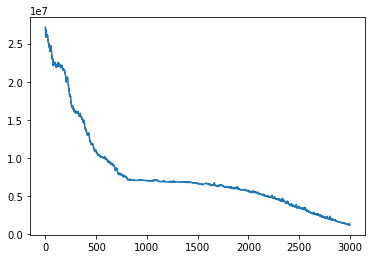

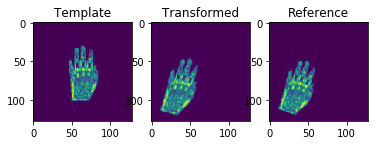

last loss: 1235958.645606778
last gradient: tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)


In [82]:
rotation_degree = 20
angle = rotation_degree * math.pi / 180.0
angle_cos = math.cos(angle)
angle_sin = math.sin(angle)
transformMatrix1 = V(t.Tensor([[angle_cos, -angle_sin, -0.0], \
                              [angle_sin, angle_cos, -0.0], \
                               [0.0, 0.0, 1.0]]).double(), True)
hand_reference_rotate = affine_transform(hand_template, transformMatrix1)
gradient_decent(hand_template, hand_reference_rotate, iteration=3000)

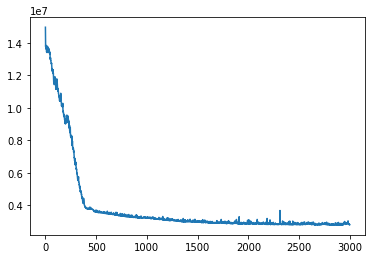

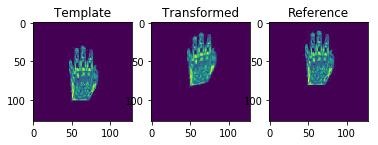

last loss: 2809572.6544127413
last gradient: tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)


In [86]:
# 2. Translate
translate_degree = 20

transformMatrix1 = V(t.Tensor([[1.0, 0.0, translate_degree], \
                               [0.0, 1.0, -0.0], \
                               [0.0, 0.0, 1.0]]).double(), True)
hand_reference_rotate = affine_transform(hand_template, transformMatrix1)
gradient_decent(hand_template, hand_reference_rotate, iteration=3000, learning_rate=1e-10)

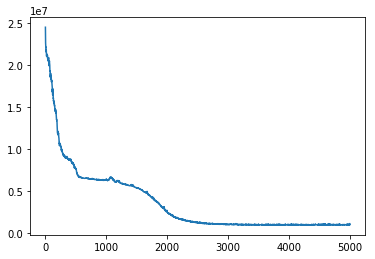

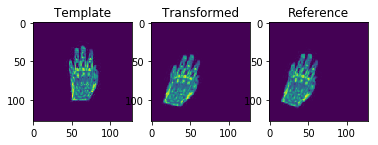

last loss: 999724.486856539
last gradient: tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)


In [85]:
# 3. Translate and Rotation
rotation_degree = 20
translate_degree = 10
angle = rotation_degree * math.pi / 180.0
angle_cos = math.cos(angle)
angle_sin = math.sin(angle)
transformMatrix1 = V(t.Tensor([[angle_cos, -angle_sin, translate_degree], \
                              [angle_sin, angle_cos, -0.0], \
                               [0.0, 0.0, 1.0]]).double(), True)
hand_reference_rotate = affine_transform(hand_template, transformMatrix1)
gradient_decent(hand_template, hand_reference_rotate, iteration=5000, learning_rate=1e-10)

### Brain Test Case

TypeError: expected torch.FloatTensor (got torch.DoubleTensor)

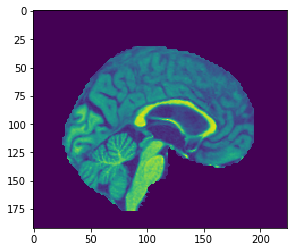

In [144]:
brain_template = plt.imread('MRI_2D/fixed1.png')
plt.imshow(brain_template)
brain_template = V(t.Tensor(hand_template).double(), True)